# COM S 574 Final Project - Mitchell Yenawine

Note: This code makes use of code from a different project that I am currently working on and is still in need of commenting and possible refinement. Since I did not realize this code was to be submitted for the project it is still in a very 'alpha' state, with poor commenting, readablility, and description.

In [1]:
import os
import operator
import sklearn, sklearn.tree
import pickle
import numpy as np
import astropy as astr
import matplotlib.pyplot as plt
import pandas as pd
import lightkurve as lk
import astroquery as aq
import astropy.units as u
import joblib as jl 
from astropy.io import fits
from sklearn import tree
import warnings
from lightkurve import LightkurveWarning
warnings.filterwarnings("ignore", category=LightkurveWarning) 

%matplotlib inline

In [43]:
def get_gaia_table(ra,dec,radius = 5*u.arcmin):
    from astroquery.gaia import Gaia
    Gaia.ROW_LIMIT = 5
    obj = astr.coordinates.SkyCoord(ra*u.deg,dec*u.deg)
    return Gaia.query_object_async(obj,width=radius,height=radius)[0]

def lomb(time, flux):
    from astropy.timeseries import lombscargle

    ls = lombscargle.LombScargle(time,flux,normalization='psd')
    freq = ls.autofrequency()
    power = ls.autopower()
    # freq = freq.value
    power = power[1]
    nyq_freq = 0.5/np.median(np.diff(time))

    w = freq < nyq_freq
    freq = freq[w]
    power = np.sqrt(power[w])
    
    return freq, power, ls

def find_peaks(freq, power, num=5, nstd=2):
    
    diff = np.diff(power)
    freq = freq[1:]
    power = power[1:]
    level = np.std(power)*nstd + np.median(power)
    
    peaks_freq = []
    peaks_power = []
    diff_last = diff[0]
    peak_found = False

    temp_freq = 0
    temp_power = 0
    
    for i in range(len(freq)):
        if power[i] < level:
            peak_found = False
            continue
            
        if diff[i] >= 0:
            temp_freq = freq[i]
            temp_power = power[i]
            peak_found = False
            diff_last = diff[i]
            continue 
            
        if (diff[i] < 0) and not peak_found:
            peaks_freq.append(temp_freq)
            peaks_power.append(temp_power)
            peak_found = True
    
    peaks_freq = np.asarray(peaks_freq)
    peaks_power = np.asarray(peaks_power)
    w = peaks_power.argsort()[::-1]
    
    peaks_freq = peaks_freq[w]
    peaks_power = peaks_power[w]

    return peaks_freq[:num], peaks_power[:num]


def get_TESS_gaia(TIC_ID):
    
    lc = lk.search_lightcurve('TIC {}'.format(TIC_ID), mission='TESS')
    lc.exptime.sort()

    lc = lc[0].download()
    lc = lc.remove_nans()
    
    ra = lc.hdu[0].header['RA_OBJ']
    dec = lc.hdu[0].header['DEC_OBJ']
    
    time = lc.time.value
    flux = lc.flux.value
    mag = -2.5*np.log10(flux)
    
    freq, power, ls = lomb(time, mag)    
    
    gaia = get_gaia_table(ra,dec,radius=2*u.arcmin)    

    return time, flux, mag, ls, gaia, freq, power


def get_star_properties(ls, gaia, freq, power):
    
    peak_freq, peak_power = find_peaks(freq, power, num=3, nstd=1)
    peak_period = 1.0 / peak_freq
    
    peak_amp = []
    for i in range(3):
        y_mod = ls.model(t = lc.time.value, frequency = peak_freq[i])
        peak_amp.append((y_mod.max() - y_mod.min())/2)

    B_V = gaia['bp_g']
    B_R = gaia['bp_rp']
    V_R = gaia['g_rp']
    Teff = gaia['teff_val']

    return B_V, B_R, V_R, Teff, peak_period, peak_freq, peak_power, peak_amp

def plot_lc(time, flux, ls, TIC_ID):
    
    freq = ls.autofrequency()
    power = ls.autopower(normalization='psd')

    nyq_freq = 0.5/np.median(np.diff(time))

    w = freq < nyq_freq
    freq = freq[w]
    power = np.sqrt(power[w])    
    
    fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(8,12))
    
    ax[0].plot(time, flux,'k-')
    ax[0].set_xlabel('BJD - 2457000',fontsize=16)
    ax[0].set_ylabel('Flux [counts]',fontsize=16)

    ax[1].plot(freq, power,'k-')
    ax[1].set_xlabel('Frequency [$day^{-1}$]',fontsize=16)
    ax[1].set_ylabel('Power [counts]',fontsize=16)

    plt.tight_layout()
    plt.savefig('lightcurve_plots/{}.png'.format(TIC_ID),facecolor='white')
    
    return


def get_feature_data(filename):
    all_obj = pd.read_csv(filename)
    
    feature_names = ['B-V', 'B-R', 'V-R', 'Teff', 
                     'period0', 'period1', 'period1',
                      'power0', 'power1', 'power2',
                      'amp0', 'amp1', 'amp2']
    
    label_names = ['ACV', 'BCEP', 'SPB']

    if os.path.exists('./features.npy') & os.path.exists('./classes.npy'):
        features = np.load('./features.npy', allow_pickle=True)
        classes = np.load('./classes.npy', allow_pickle=True)
        return features, classes


    features = np.zeros((len(all_obj), len(feature_names)))
    cls = []

    for i in all_obj.index:
        obj = all_obj.iloc[i]        

        TIC_ID = obj['TIC']
        
        print('####################################################')
        print('Getting data from TIC {}'.format(TIC_ID))        
        print('\n \n \n')
        
        if os.path.exists('./star_data/{}.dat'.format(TIC_ID)):
            time, flux, mag, ls, gaia, freq, power = astr.io.misc.fnunpickle.load('./star_data/{}.dat'.format(TIC_ID))
        else:
            time, flux, mag, ls, gaia, freq, power  = get_TESS_gaia(TIC_ID)

            # jl.dump([lc, ls, gaia, freq, power],'./star_data/{}.dat'.format(TIC_ID))        

            with open('./star_data/{}.dat'.format(TIC_ID),'wb') as f:
                astr.io.misc.fnpickle([time, flux, mag, ls, gaia, freq, power], f)

        print('Making a plot \n \n')
        if os.path.exists('lightcurve_plots/{}.png'.format(TIC_ID)):
            continue
        else:
            plot_lc(time, flux, ls, TIC_ID)
        
        print('Getting Stellar Parameters \n \n')
        if os.path.exists('./star_parm/{}.dat'.format(TIC_ID)):
            params = astr.io.misc.fnunpickle('./star_parm/{}.dat'.format(TIC_ID))
        else:
            params = get_star_properties(ls, gaia, freq, power)
            # jl.dump(params,'./star_parm/{}.dat'.format(TIC_ID))  

            with open('./star_parm/{}.dat'.format(TIC_ID),'wb') as f:
                astr.io.misc.fnpickle(params, f)

        B_V, B_R, V_R, Teff, peak_period, peak_freq, peak_power, peak_amp = params
        
        features[i,0] = B_V
        features[i,1] = B_R
        features[i,2] = V_R
        features[i,3] = Teff
        features[i,4] = peak_period[0]
        features[i,5] = peak_period[1]
        features[i,6] = peak_period[2]
        features[i,7] = peak_power[0]
        features[i,8] = peak_power[1]
        features[i,9] = peak_power[2]
        features[i,10] = peak_amp[0]
        features[i,11] = peak_amp[1]
        features[i,12] = peak_amp[2]
        
        cls.append(obj['Type'])
    
    print('Saving features \n')
    np.save('features.npy', features, allow_pickle=True)
    np.save('classes.npy', cls, allow_pickle=True)
        
    astr.io.misc.fnpickle(features,'features.dat')  
    astr.io.misc.fnpickle(cls,'classes.dat')  
        
    return features, cls



start


In [ ]:
# Run the project

# Get features and create decision tree
print('start')
if False:
    
    feature_names = ['B-V', 'B-R', 'V-R', 'Teff', 
                     'period0', 'period1', 'period1',
                      'power0', 'power1', 'power2',
                      'amp0', 'amp1', 'amp2']
    
    label_names = ['ACV', 'BCEP', 'SPB']
    
    filename = 'obj_list_trim.csv'

    print('Starting Job \n \n \n ')


    print('Getting Features and Classes for all Stars')
    features, classes = get_feature_data(filename)
    targets = np.zeros(len(classes))
    
    for i, name in enumerate(label_names):
        w = classes == name
        targets[w] = i
    
    print('Making Decision Tree')

    decision_tree = tree.DecisionTreeClassifier(random_state=0, max_depth=5)
    decision_tree = tree.decision_tree.fit(features, targets)
    r = export_text(decision_tree, feature_names=feature_names)
    
    print('Saving Decision Tree')

    dump(decision_tree, 'dt_model.dat')


In [59]:
import numpy as np

# load features and classes from previous section

feature_names = ['B-V', 'B-R', 'V-R', 'Teff', 
                 'period0', 'period1', 'period2',
                  'power0', 'power1', 'power2',
                  'amp0', 'amp1', 'amp2']

label_names = ['ACV', 'BCEP', 'SPB']


features = np.load('features.npy')
features = features[1:]
cls = np.load('classes.npy')

w = np.asarray([np.all(f == f) for f in features])
features = features[w]
cls = cls[w]

targets = np.zeros(len(cls))

for i, name in enumerate(label_names):
    w = cls == name
    print(name, sum(w))
    targets[w] = i    


ACV 71
BCEP 40
SPB 28


In [86]:
from sklearn import tree

# create period trees with different number of levels

num_samples = len(features)
bad_predictions = True
level_stop = 12
levels = 0
rs = []
while bad_predictions and levels < level_stop:
    levels += 1

    decision_tree = tree.DecisionTreeClassifier(random_state=0, max_depth=levels)
    decision_tree = decision_tree.fit(features, targets)
    r = tree.export_text(decision_tree, feature_names=feature_names)
    
    print(r)
    
    wrong_predictions = 0
    for f, t in zip(features, targets):
        if decision_tree.predict([f])[0] == t:
            continue
        else:
            wrong_predictions += 1
    
    print('With {} levels {} % of samples are wrongly predicted'.format(levels, round(100*wrong_predictions/num_samples, 2)))
        
    fig, ax = plt.subplots(1, 1, figsize=(25,12))

    _ = tree.plot_tree(decision_tree=decision_tree, ax=ax, feature_names=feature_names,fontsize=16)

    plt.savefig('levels_{}.png'.format(levels))
    plt.close()
    
    if wrong_predictions == 0:
        bad_predictions = False
        

|--- period1 <= 0.41
|   |--- class: 1.0
|--- period1 >  0.41
|   |--- class: 0.0

With 1 levels 25.18 % of samples are wrongly predicted
|--- period1 <= 0.41
|   |--- period1 <= 0.27
|   |   |--- class: 1.0
|   |--- period1 >  0.27
|   |   |--- class: 1.0
|--- period1 >  0.41
|   |--- period2 <= 1.27
|   |   |--- class: 2.0
|   |--- period2 >  1.27
|   |   |--- class: 0.0

With 2 levels 19.42 % of samples are wrongly predicted
|--- period1 <= 0.41
|   |--- period1 <= 0.27
|   |   |--- class: 1.0
|   |--- period1 >  0.27
|   |   |--- power1 <= 0.12
|   |   |   |--- class: 1.0
|   |   |--- power1 >  0.12
|   |   |   |--- class: 2.0
|--- period1 >  0.41
|   |--- period2 <= 1.27
|   |   |--- B-V <= -0.02
|   |   |   |--- class: 0.0
|   |   |--- B-V >  -0.02
|   |   |   |--- class: 2.0
|   |--- period2 >  1.27
|   |   |--- V-R <= -0.04
|   |   |   |--- class: 0.0
|   |   |--- V-R >  -0.04
|   |   |   |--- class: 0.0

With 3 levels 16.55 % of samples are wrongly predicted
|--- period1 <= 0.


With 8 levels 0.0 % of samples are wrongly predicted


##### Misc Working Code for graphs 

<Figure size 432x288 with 0 Axes>

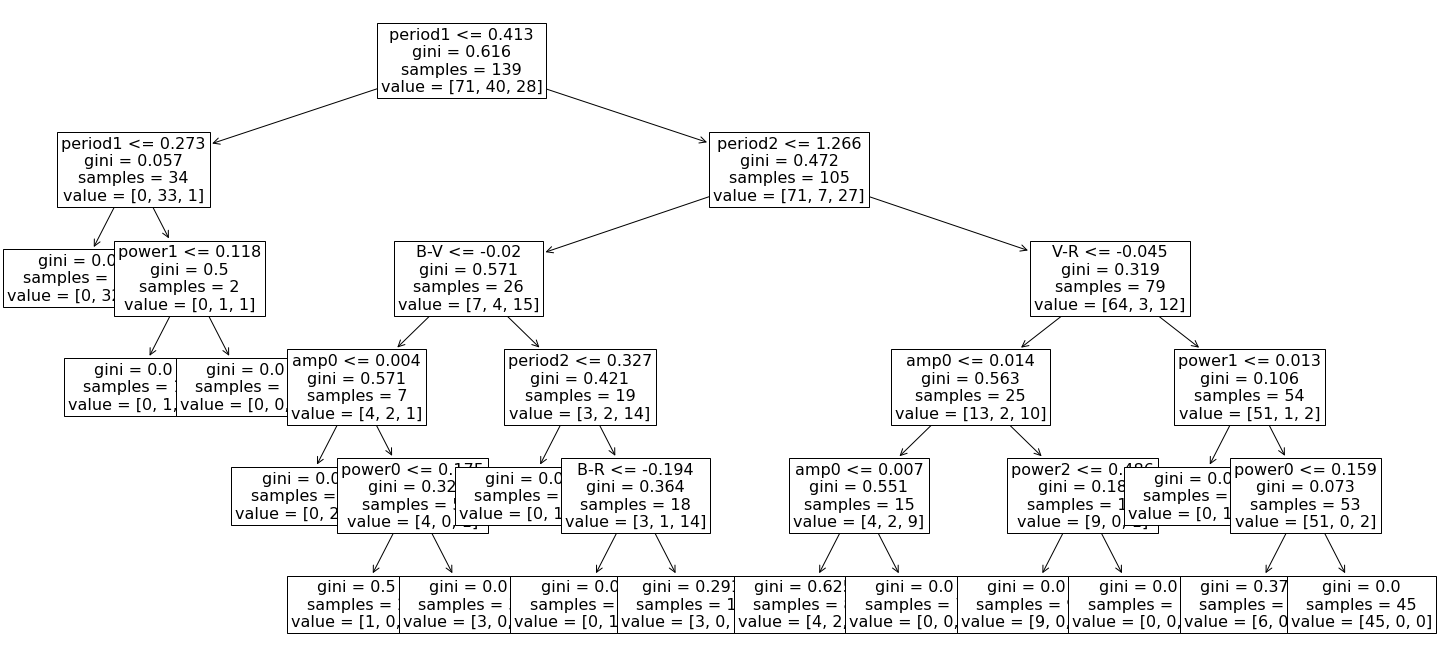

<Figure size 432x288 with 0 Axes>

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(25,12))

_ = tree.plot_tree(decision_tree=decision_tree, ax=ax, feature_names=feature_names,fontsize=16)

plt.figure('levels_{}.png'.format(levels))

In [98]:
tree.export_graphviz(decision_tree=decision_tree, out_file='graphic.dot',feature_names=feature_names,class_names=label_names)

In [33]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
iris = load_iris()
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=2)
decision_tree = decision_tree.fit(iris.data, iris.target)
r = export_text(decision_tree, feature_names=iris['feature_names'])
print(r)

|--- petal width (cm) <= 0.80
|   |--- class: 0
|--- petal width (cm) >  0.80
|   |--- petal width (cm) <= 1.75
|   |   |--- class: 1
|   |--- petal width (cm) >  1.75
|   |   |--- class: 2



In [90]:
import corner

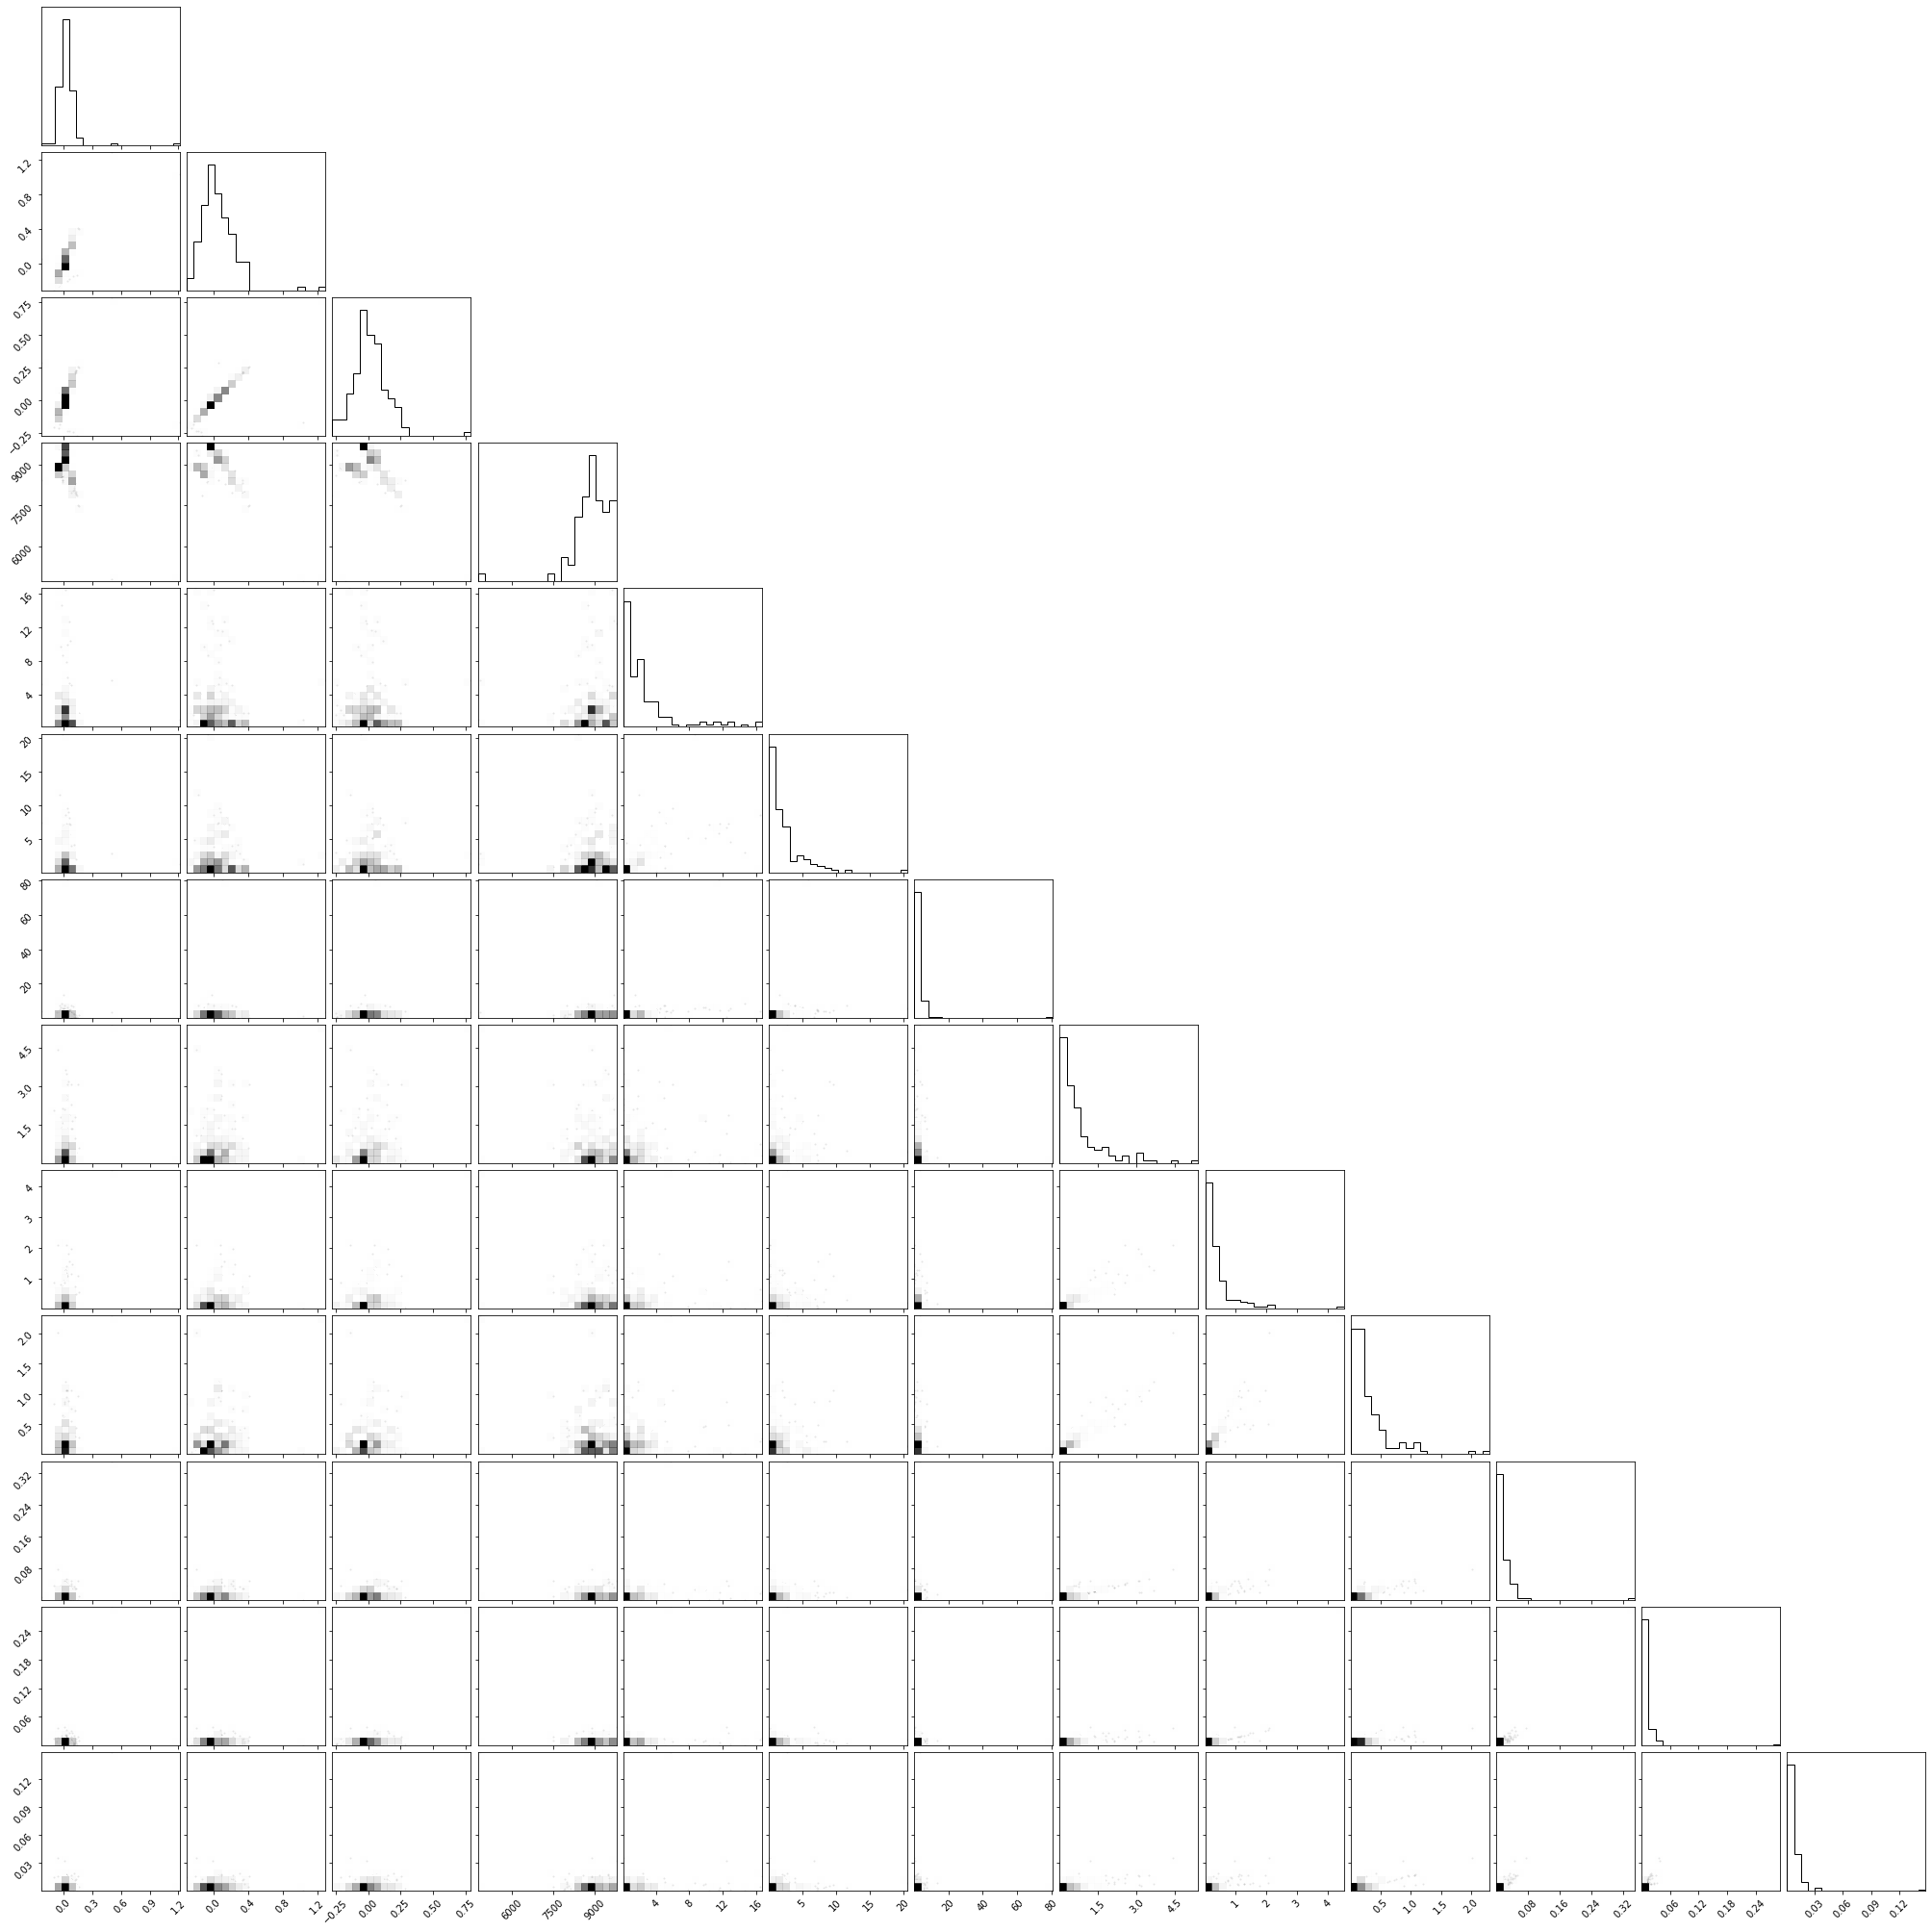

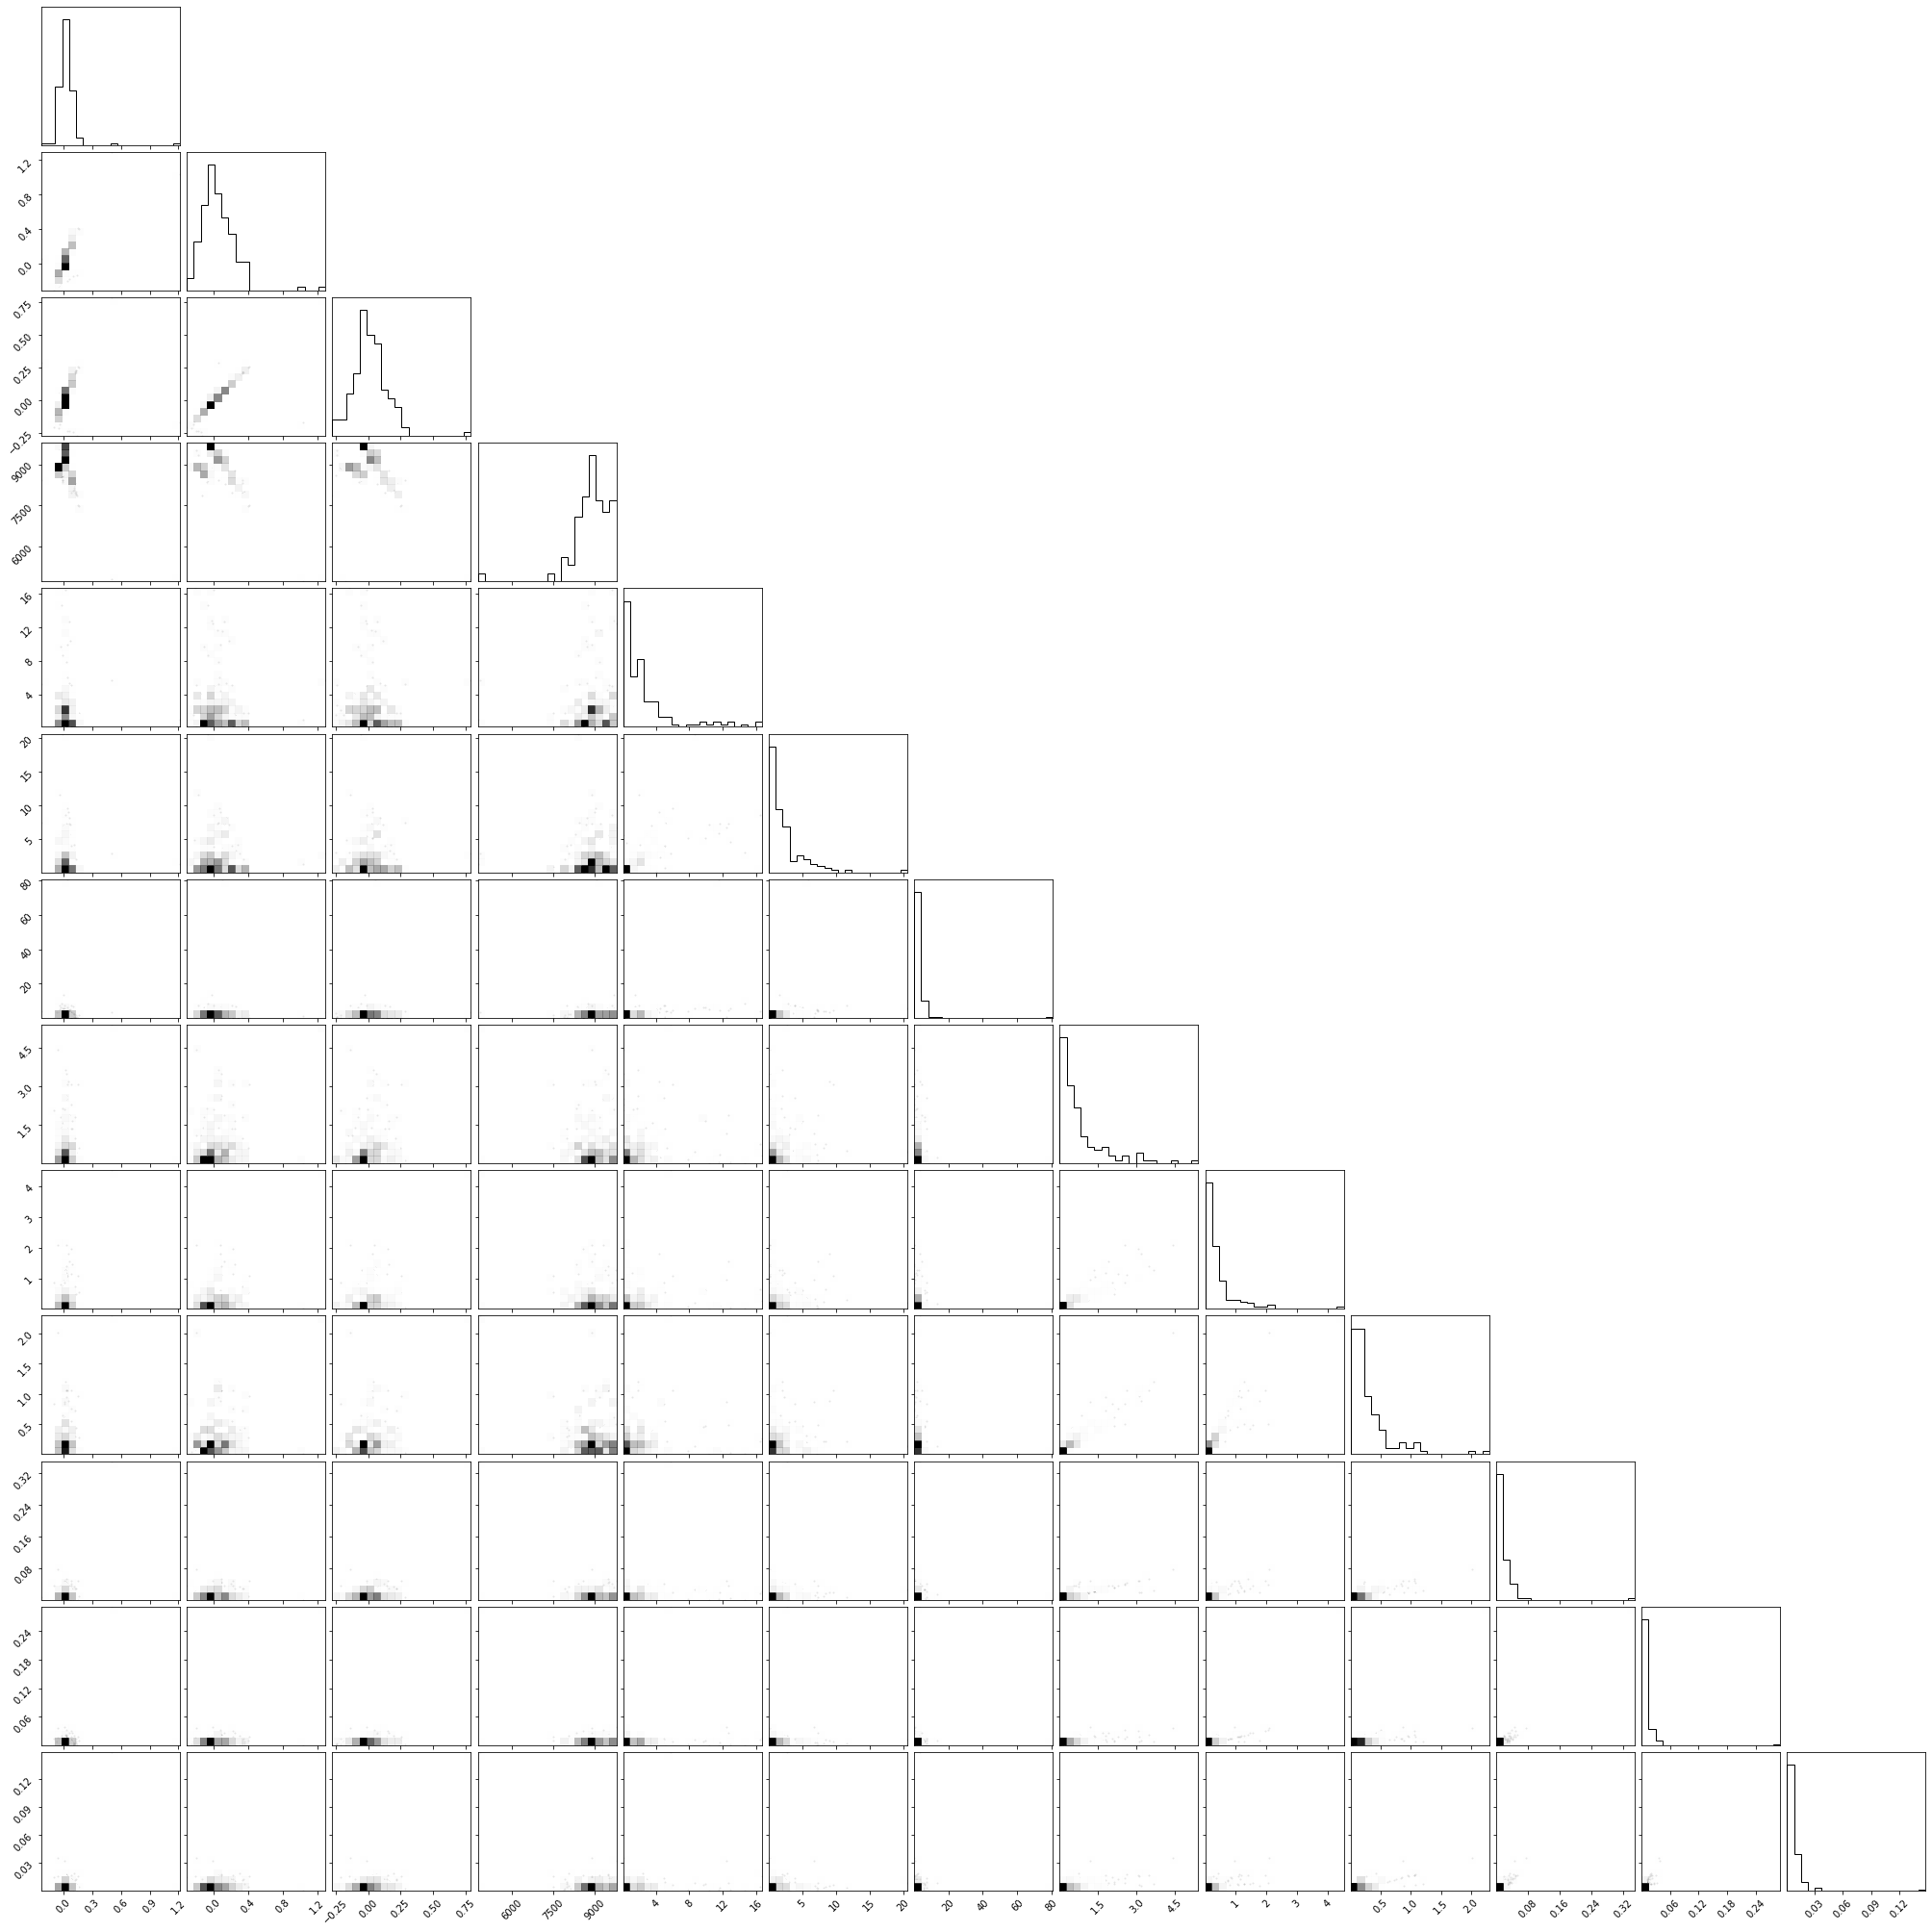

In [105]:
corner.corner(features, smooth=None,titles=label_names,plot_contours=False,)

In [124]:
features_trim = features[:,[0,2,5,6,7,8,10]]


labels = ['B-V', 'V-R', 'period 1', 'period 2', 'power 0', 'power 1', 'amp 0']

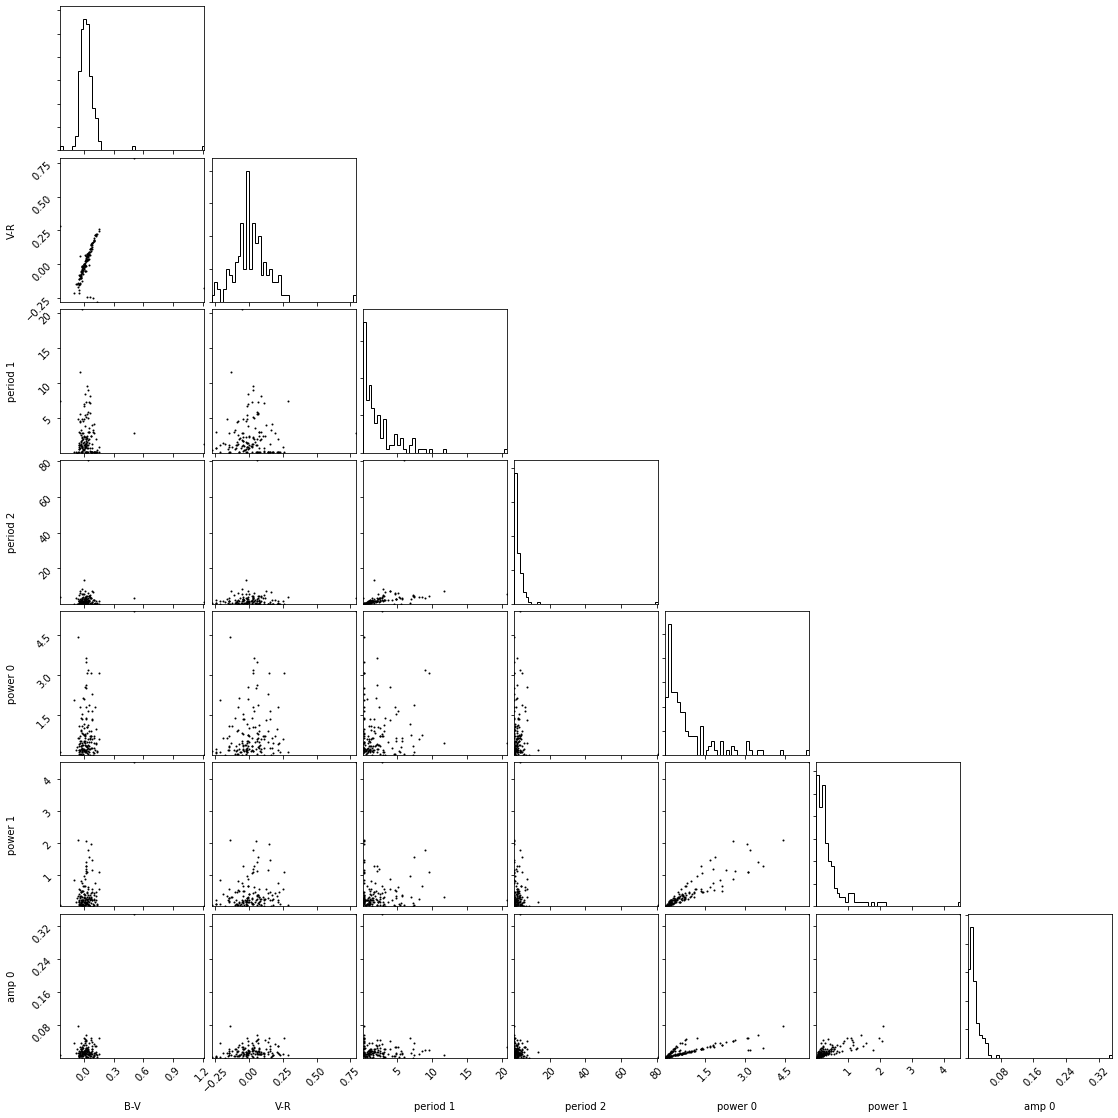

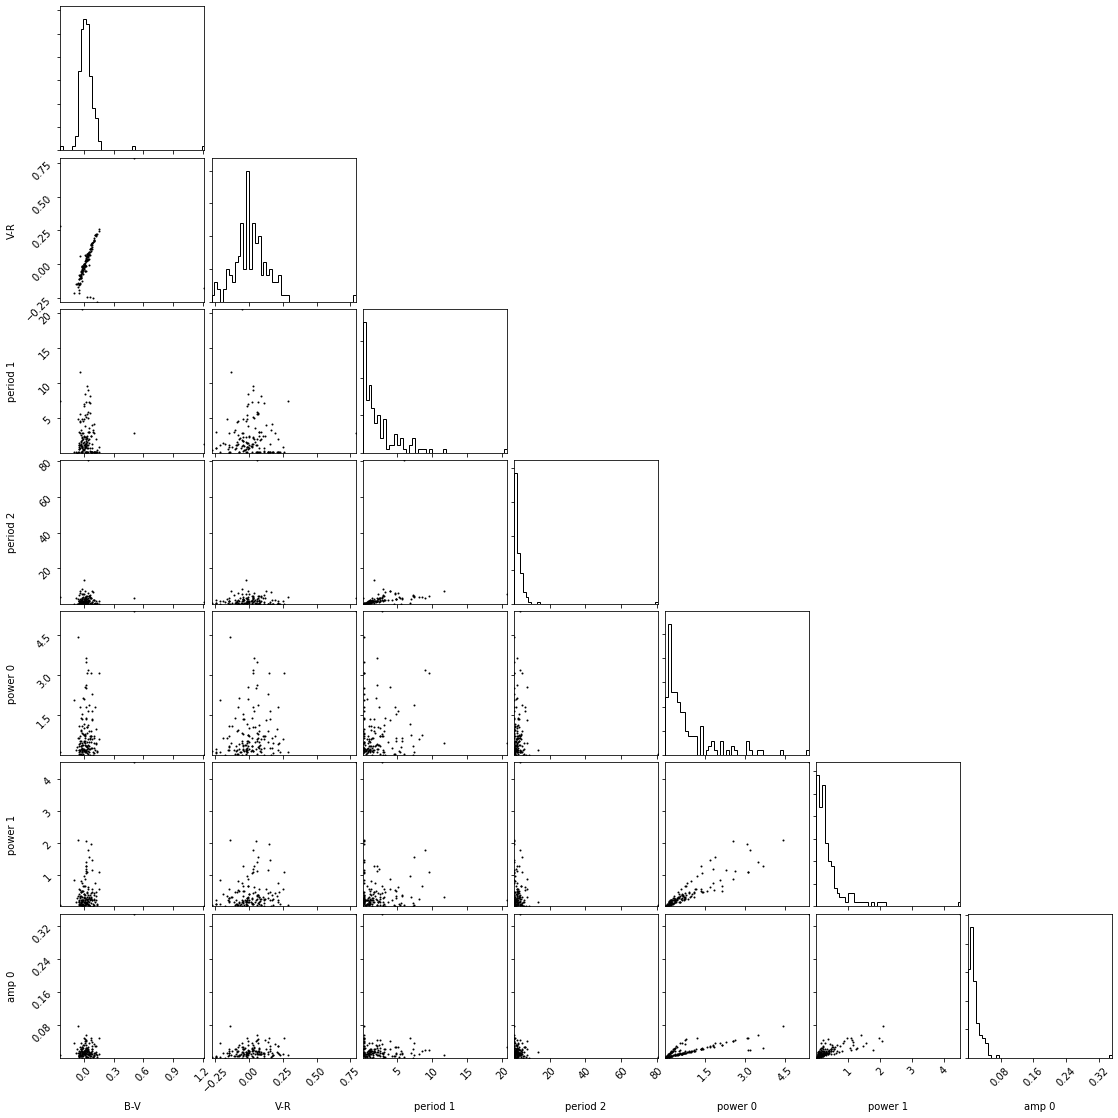

In [125]:
corner(features_trim,plot_contours=False,labels=labels)

In [40]:
lc_search = lk.search_lightcurve('TIC81096153',sector=7)
lc_search.exptime.sort()
data = lc_search[0].download()

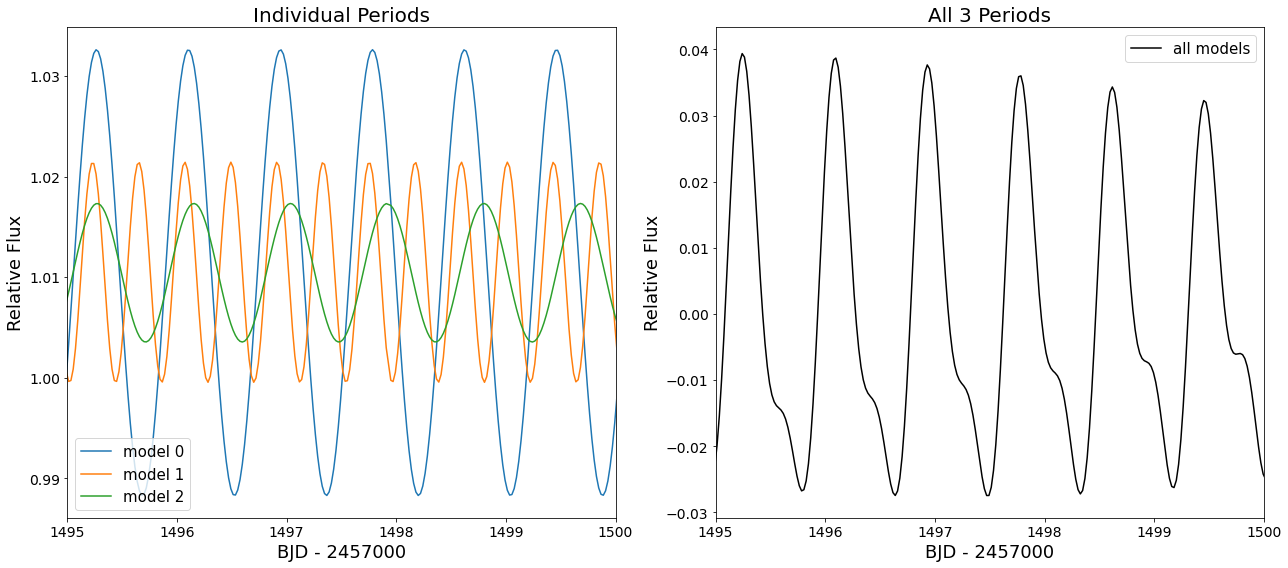

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))

time = data.time.value
flux = data.flux.value

freq, power, ls = lomb(time, flux)

peak_freq, peak_power = find_peaks(freq, power, num=3, nstd=1)
peak_period = 1.0 / peak_freq

peak_amp = []

all_mods = np.zeros(len(time))

for i in range(3):
    y_mod = ls.model(t = time, frequency = peak_freq[i])
    peak_amp.append((y_mod.max() - y_mod.min())/2)
    
    all_mods += y_mod - np.median(y_mod)
    
    ax[0].plot(time, y_mod, '-', label='model {}'.format(i))
    ax[0].set_title('Individual Periods',fontsize=20)
    ax[0].set_xlim(1495,1500)
    ax[0].set_xlabel('BJD - 2457000',fontsize=18)
    ax[0].set_ylabel('Relative Flux',fontsize=18)
    ax[0].tick_params(labelsize=14)
    
ax[0].legend(fontsize=15)

ax[1].plot(time, all_mods, 'k-',label='all models')
ax[1].set_title('All 3 Periods',fontsize=20)

ax[1].set_xlim(1495,1500)
ax[1].set_xlabel('BJD - 2457000',fontsize=18)
ax[1].set_ylabel('Relative Flux',fontsize=18)
ax[1].tick_params(labelsize=14)
plt.legend(fontsize=15)

plt.tight_layout()
plt.savefig('lomb_models.png',facecolor='white')